In [4]:
import pynbody
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pynbody import units
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from scipy import stats
from scipy import constants
import pynbody.filt as f

In [5]:
pynbody.config['sph']['smooth-particles'] = 50

In [7]:
s = pynbody.load('../Documents/Bachelorthesis/simulations/g8.26files/g8.26e11.01024')
#s2 = pynbody.load('output_279/2.79e12.02000')
h = s.halos()
#h2 = s2.halos()

# main halo
h1 = h[1]
#h2_main = h2[1]

# convert to physical units
s.physical_units()

# face on
pynbody.analysis.angmom.faceon(h1)

(10*1.673*10**(-27)*units.kg/units.cm**3).ratio(units.Msol/units.kpc**3)
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
sf = f.HighPass('rho', '247133368.31459114 Msol kpc^-3') & f.LowPass('temp', '30000 K')
low_alpha = f.LowPass('alpha', '100')

gal = h1[disk]
gal_sf = gal.g[sf]

In [9]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def vel_div(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating velocity divergence')
    
    vel_div = self.kdtree.sph_divergence(self['vel'], nsmooth=pynbody.config['sph']['smooth-particles'])


    return vel_div

In [12]:
gal['vel_div']

ValueError: The particles span a region larger than the specified boxsize

In [13]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def vel_curl(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating velocity curl')
    
    vel_curl = self.kdtree.sph_curl(self['vel'], nsmooth=pynbody.config['sph']['smooth-particles'])

    return vel_curl


In [14]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def mass_sph(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating sph mean')
    
    mass_sph = self.kdtree.sph_mean(self['mass'], nsmooth=pynbody.config['sph']['smooth-particles'])
    

    return mass_sph

In [15]:
@pynbody.snapshot.SimSnap.derived_quantity
def vel_curl2(self):
    """Squared velocity"""
    return (self['vel_curl'] ** 2).sum(axis=1)

In [16]:
# mass weighted 2d histograms

def mw_hist(fam, key, b):
    hist, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam[key]*fam['mass'], bins=b, range=((-50,50),(-50,50)))
    mass, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam['mass'], bins=b, range=((-50,50),(-50,50)))
    return hist/mass


In [17]:
# comparison mass m_i of particle or mass = rho_i * V_i of the kernel

m_part = gal.g['mass']
m_kern = gal.g['rho']*4/3*np.pi*gal.g['smooth']**3
print(m_part[0])
print(m_kern[0])

317208.65322694846
2207311.782252463


In [ ]:
gal.g['radius2'] = gal.g['smooth']
gal.g['radius2'] = (gal.g['mass']/gal.g['rho']*3/(4*np.pi))**(1/3)
gal.g['radius2']

SimArray([0.05389749, 0.02573586, 0.09738497, ..., 0.09887704, 0.05497814,
          0.04373926], 'kpc')

In [ ]:
gal.g['alpha'] = (5*gal.g['v_disp']**2*gal.g['smooth']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_kern)).in_units(1)
gal.g['alpha_2'] = (5*gal.g['v_disp']**2*gal.g['radius2']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_part)).in_units(1)
#gal.g['alpha_3'] = -2*gal.g['ke']/
gal.g['alpha_4'] = 1/4*(np.abs(gal.g['velo_div'])+np.sqrt(gal.g['velo_curl2']))/(constants.G*units.m**3*units.kg**-1*gal.g['rho'])
b = 2.02
gal.g['efficiency'] = np.exp(-b*gal.g['alpha']**(1/2))
gal_low_alpha = gal.g[low_alpha]

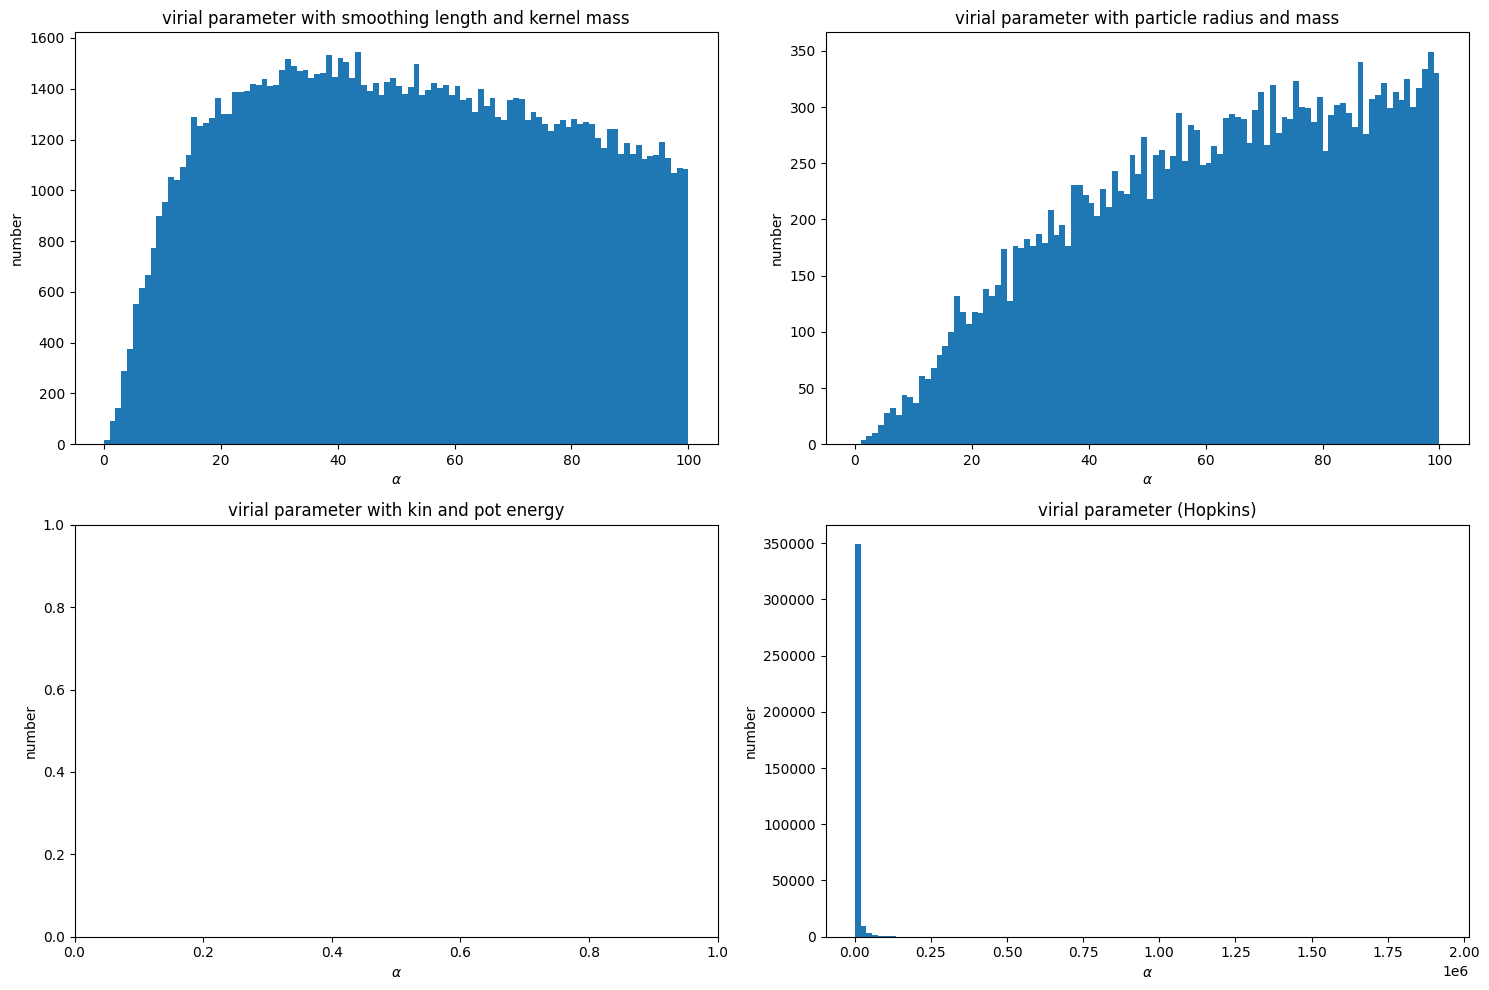

In [68]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(221)
ax1.hist(gal.g['alpha'], bins = 100, range= (0,100))
ax1.set_title('virial parameter with smoothing length and kernel mass')
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('number')


ax2 = plt.subplot(222)
ax2.hist(gal.g['alpha_2'], bins = 100, range=(0,100))
ax2.set_title('virial parameter with particle radius and mass')
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('number')


ax3 = plt.subplot(223)
#ax3.hist(gal.g['alpha_3'], bins = 100)
ax3.set_title('virial parameter with kin and pot energy')
ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel('number')


ax4 = plt.subplot(224)
ax4.hist(gal.g['alpha_4'], bins = 100)
ax4.set_title('virial parameter (Hopkins)')
ax4.set_xlabel(r'$\alpha$')
ax4.set_ylabel('number')



fig.tight_layout()
plt.show()

/tmp/ipykernel_488/3198553351.py:6: RuntimeWarning: invalid value encountered in divide
  return hist/mass


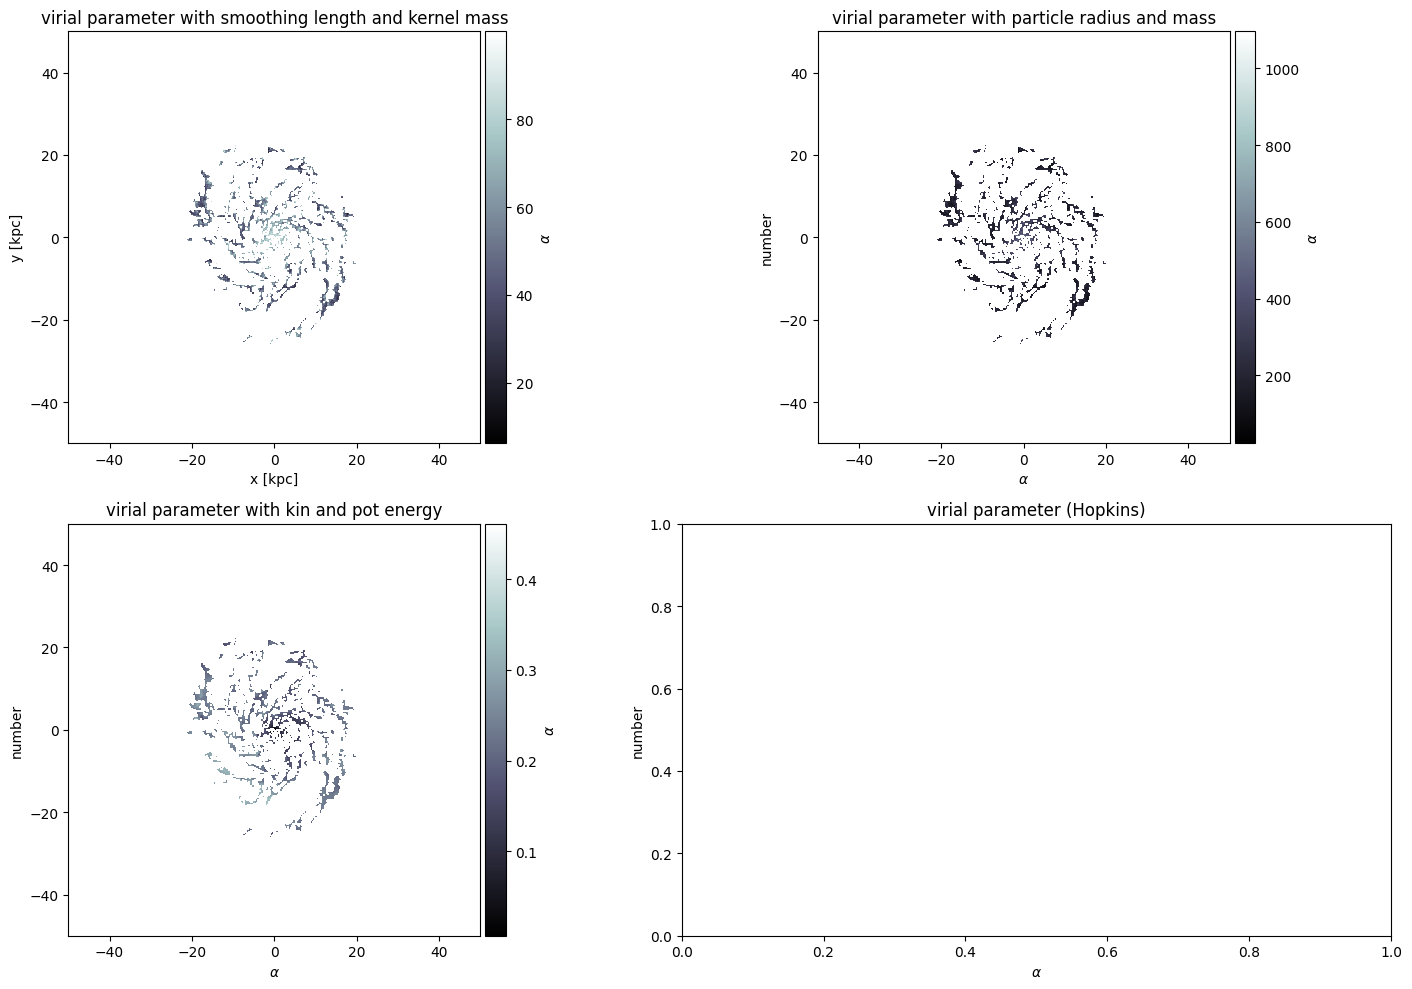

In [ ]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(221)
im1 = ax1.imshow(mw_hist(gal_low_alpha, 'alpha', 500), extent=(-50,50,-50,50), cmap='bone')
ax1.imshow(mw_hist(gal_low_alpha, 'alpha', 500), extent=(-50,50,-50,50), cmap='bone')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'$\alpha$')
ax1.set_title('virial parameter with smoothing length and kernel mass')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
ax1.set_xlim(-50, 50)
ax1.set_ylim(-50, 50)

ax2 = plt.subplot(222)
im2 = ax2.imshow(mw_hist(gal_low_alpha, 'alpha_2', 500), extent=(-50,50,-50,50), cmap='bone')
ax2.imshow(mw_hist(gal_low_alpha, 'alpha_2', 500), extent=(-50,50,-50,50), cmap='bone')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = r'$\alpha$')
ax2.set_title('virial parameter with particle radius and mass')
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('number')
#ax2.set_xlim(-20, 20)
#ax2.set_ylim(-20,20)

ax3 = plt.subplot(223)
im3 = ax3.imshow(mw_hist(gal_low_alpha, 'alpha_3', 500), extent=(-50,50,-50,50), cmap='bone')
#ax3.imshow(mw_hist(gal_low_alpha, 'alpha_3', 500), extent=(-50,50,-50,50), cmap='bone')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im3, cax=cax, orientation='vertical', label = r'$\alpha$')
ax3.set_title('virial parameter with kin and pot energy')
ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel('number')
#ax3.set_xlim(-20, 20)
#ax3.set_ylim(-20,20)

ax4 = plt.subplot(224)
#ax4.imshow(mw_hist(gal.g, 'alpha_4', 500), extent=(-50,50,-50,50), cmap='bone')
#divider = make_axes_locatable(ax4)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im4, cax=cax, orientation='vertical', label = r'$\alpha$')
ax4.set_title('virial parameter (Hopkins)')
ax4.set_xlabel(r'$\alpha$')
ax4.set_ylabel('number')
#ax4.set_xlim(-20, 20)
#ax4.set_ylim(-20,20)


fig.tight_layout()
plt.show()

(array([  17.,   92.,  142.,  287.,  377.,  552.,  617.,  666.,  774.,
         899.,  953., 1051., 1039., 1092., 1138., 1287., 1252., 1266.,
        1284., 1364., 1299., 1299., 1387., 1387., 1391., 1420., 1416.,
        1437., 1410., 1414., 1472., 1519., 1491., 1469., 1475., 1442.,
        1460., 1463., 1532., 1446., 1523., 1505., 1441., 1545., 1413.,
        1392., 1423., 1375., 1426., 1443., 1409., 1381., 1408., 1498.,
        1375., 1397., 1424., 1404., 1415., 1375., 1408., 1357., 1362.,
        1309., 1398., 1332., 1362., 1289., 1277., 1357., 1364., 1359.,
        1276., 1308., 1290., 1262., 1234., 1262., 1278., 1250., 1281.,
        1263., 1269., 1261., 1205., 1167., 1243., 1241., 1142., 1187.,
        1142., 1178., 1125., 1135., 1141., 1191., 1127., 1067., 1087.,
        1084.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.

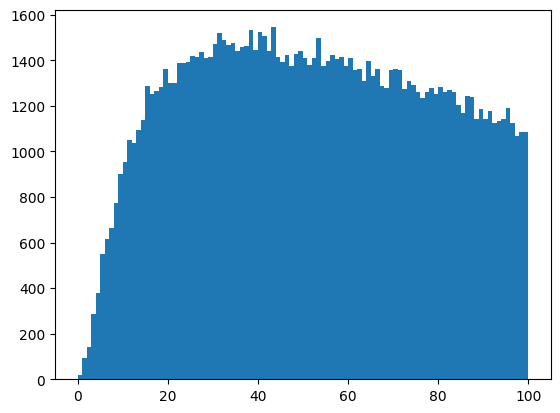

In [159]:
plt.hist(gal.g['alpha'],bins=100,range=(0,100))

(array([  0.,   4.,   7.,  10.,  17.,  28.,  32.,  26.,  44.,  42.,  37.,
         61.,  58.,  68.,  79.,  87., 100., 132., 118., 107., 118., 117.,
        138., 132., 142., 174., 127., 176., 175., 183., 176., 187., 179.,
        208., 186., 195., 176., 231., 231., 222., 215., 203., 227., 211.,
        243., 225., 223., 257., 240., 273., 218., 257., 262., 245., 256.,
        295., 252., 284., 280., 248., 250., 265., 258., 290., 294., 291.,
        289., 268., 297., 313., 266., 320., 277., 291., 289., 323., 300.,
        299., 287., 309., 261., 293., 302., 304., 295., 282., 340., 276.,
        307., 311., 321., 299., 313., 306., 325., 300., 317., 334., 349.,
        330.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  4

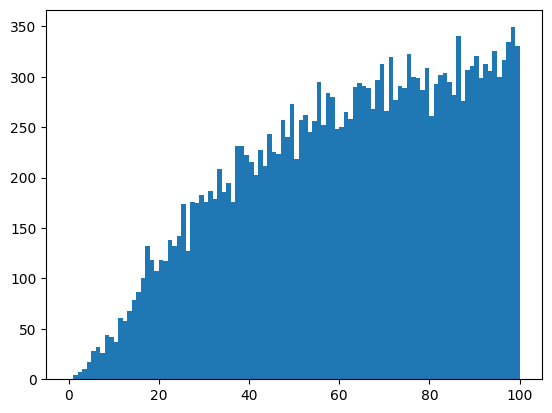

In [160]:
plt.hist(gal.g['alpha_2'],bins=100,range=(0,100))

In [32]:
# densities
#g_hist, g_xbins, g_ybins = np.histogram2d(gal.g['x'],gal.g['y'],weights=gal.g['rho'], bins=500, range=((-50,50),(-50,50)))
#s_hist, s_xbins, s_ybins = np.histogram2d(gal.s['x'],gal.s['y'],weights=gal.s['rho'], bins=500, range=((-50,50),(-50,50)))
g_hist, g_xedge, g_yedge, g_bin  = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['rho'], statistic = 'mean', bins = 500)
s_hist, s_xedge, s_yedge, s_bin = stats.binned_statistic_2d(gal.s['x'],gal.s['y'], gal.s['rho'], statistic = 'mean', bins = 500)

alpha_hist, a_xbins, a_ybins, a_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['alpha'], statistic = 'mean', bins = 200)
eff_hist, e_xedges, e_yedges, e_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['efficiency'], statistic = 'mean', bins = 200)




In [25]:
pg1 = pynbody.analysis.profile.Profile(gal.g, min = 0.01, max = 50, type = 'equaln')
ps1 = pynbody.analysis.profile.Profile(gal.s, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha = pynbody.analysis.profile.Profile(gal_low_alpha.g, min = 0.01, max = 50, type = 'equaln')

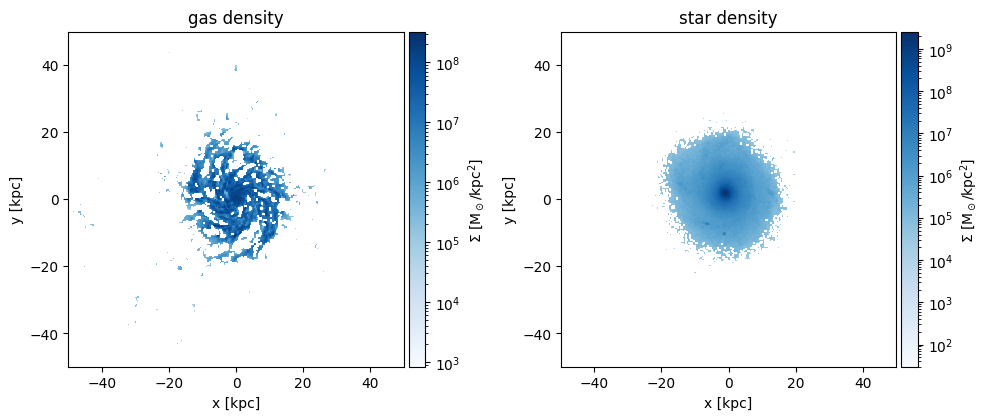

In [27]:

fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot(121)
im1 = ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

ax2 = plt.subplot(122)
im2 = ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax2.set_title('star density')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
#ax1.xlim(-30, 30)
#ax1.ylim(-30,30)

fig.tight_layout()
plt.show()

In [13]:
np.median((5*gal.g['v_disp']**2*gal.g['smooth']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_kern)).in_units(1))

SimArray(165.99309388, '1.00e+00')

/tmp/ipykernel_271/3198553351.py:6: RuntimeWarning: invalid value encountered in divide
  return hist/mass


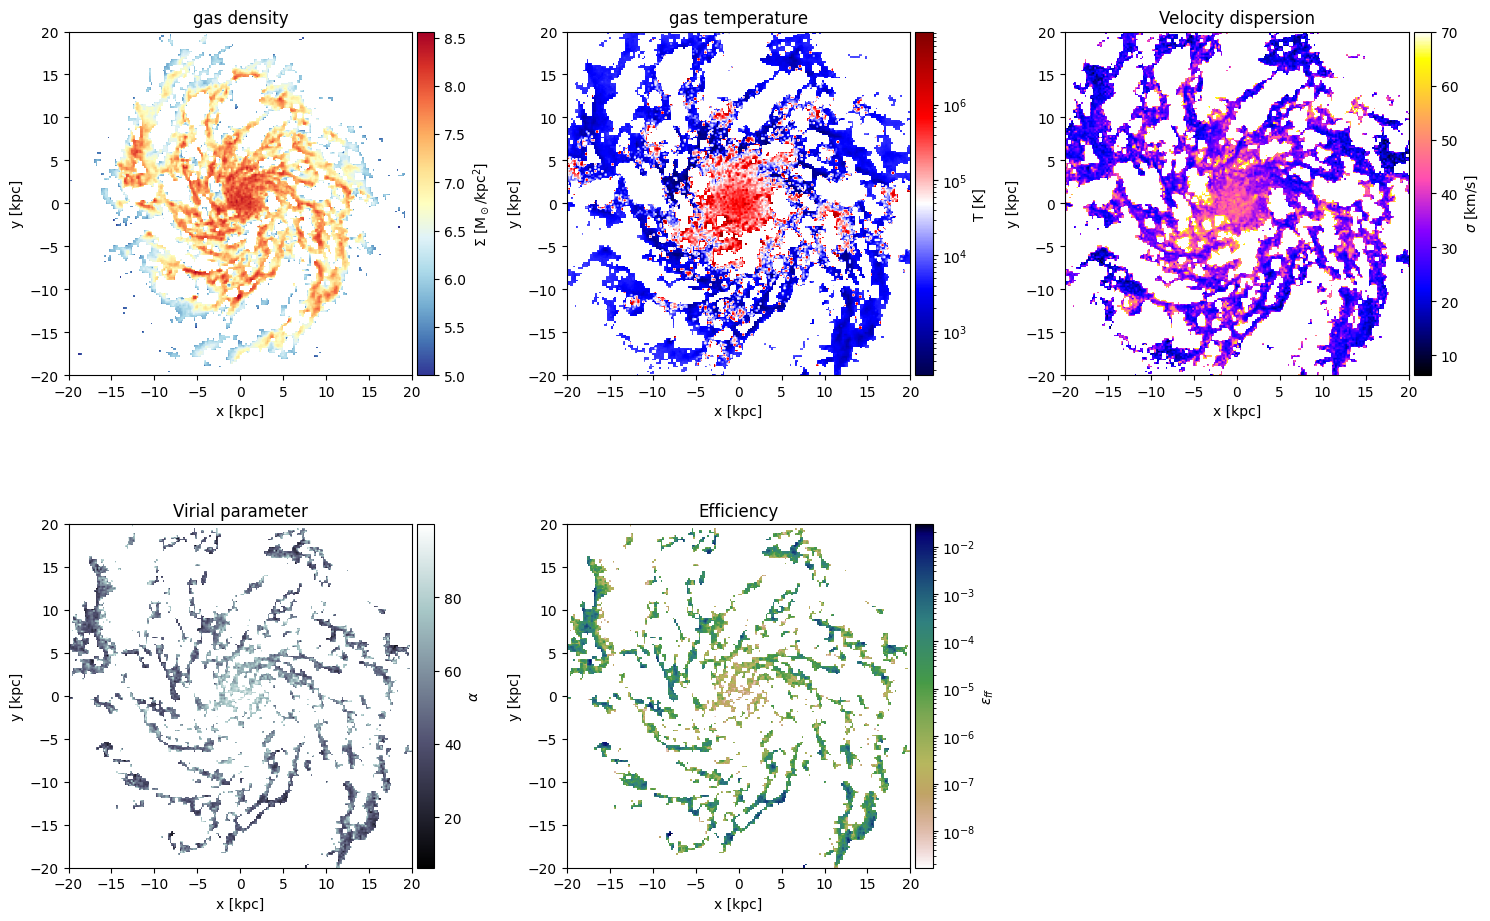

In [193]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(231)
im1 = ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 5)
ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = 'log($\Sigma$) [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
ax1.set_xlim(-20, 20)
ax1.set_ylim(-20,20)

ax2 = plt.subplot(232)
im2 = ax2.imshow(np.log10(mw_hist(gal.g,'temp',500)), cmap='seismic', extent=(-50,50,-50,50), vmin = )
ax2.imshow(mw_hist(gal.g,'temp',500), cmap='seismic', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = 'T [K]')
ax2.set_title('gas temperature')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
ax2.set_xlim(-20, 20)
ax2.set_ylim(-20,20)

ax3 = plt.subplot(233)
im3 = ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15, vmax = 70)
ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15,vmax = 70)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label =r'$\sigma$ [km/s]')
ax3.set_title('Velocity dispersion')
ax3.set_xlabel('x [kpc]')
ax3.set_ylabel('y [kpc]')
ax3.set_aspect('equal')
ax3.set_xlim(-20, 20)
ax3.set_ylim(-20,20)

ax4 = plt.subplot(234)
im4 = ax4.imshow(mw_hist(gal_low_alpha,'alpha',500), extent=(-50,50,-50,50), cmap='bone')
ax4.imshow(mw_hist(gal_low_alpha,'alpha',500), extent=(-50,50,-50,50), cmap='bone')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label = r'$\alpha$')
ax4.set_title('Virial parameter')
ax4.set_xlabel('x [kpc]')
ax4.set_ylabel('y [kpc]')
ax4.set_aspect('equal')
ax4.set_xlim(-20, 20)
ax4.set_ylim(-20,20)

ax5 = plt.subplot(235)
im5 = ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical', label = r'$\epsilon_{ff}$')
ax5.set_title('Efficiency')
ax5.set_xlabel('x [kpc]')
ax5.set_ylabel('y [kpc]')
ax5.set_aspect('equal')
ax5.set_xlim(-20, 20)
ax5.set_ylim(-20,20)


fig.tight_layout()
plt.show()

(-50.0, 50.0)

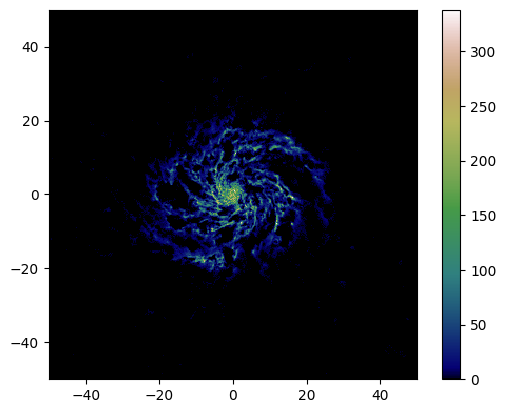

In [42]:
plt.hist2d(gal.g['x'], gal.g['y'], cmap = 'gist_earth', bins = 500)
axes = plt.gca()
axes.set_aspect(1./axes.get_data_ratio())
plt.colorbar()
plt.xlim(-50,50)
plt.ylim(-50,50)


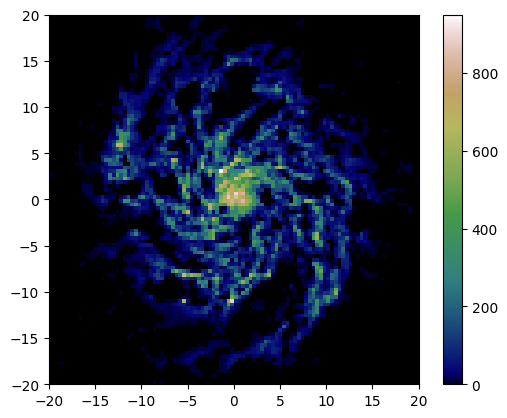

In [214]:
hist, x_edge, y_edge = np.histogram2d(gal.g['x'],gal.g['y'], bins=250)

plt.imshow(hist, cmap='gist_earth', extent=(-50,50,-50,50))
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.colorbar()

In [215]:
print(np.mean(hist[hist>0]))

48.80510968432317


In [216]:
dx = (gal.g['x'].max()-gal.g['x'].min())/250
dy = (gal.g['y'].max()-gal.g['y'].min())/250
dz = gal.g['z'].max()-gal.g['z'].min()
R = 1/2*np.sqrt(dx**2+dy**2+dz**2)

In [217]:
R

SimArray(0.64268406, 'kpc')

In [218]:
gal.g['velo2'] = gal.g['v_disp']
gal.g['velo2'] = gal.g['v2']**(1/2)
gal.g['velo2']

SimArray([203.22685035, 182.82258255, 193.41180633, ..., 205.71815459,
          217.32922663, 176.42778165], 'km s**-1')

In [219]:
mass_hist, mass_xedge, mass_yedge, mass_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['mass'], statistic = 'sum', bins=250)
vdisp_hist, vdisp_xedge, vdisp_yedge, vdisp_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['velo2'], statistic = 'std', bins=250)



In [221]:
a_hist = np.zeros((250,250))
for i in range(250):
    for j in range(250):
        a_hist[i][j] = 5*(vdisp_hist[i][j]*units.km*units.s**-1)**2*R/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*mass_hist[i][j]*units.Msol)


(array([[ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 85.,  

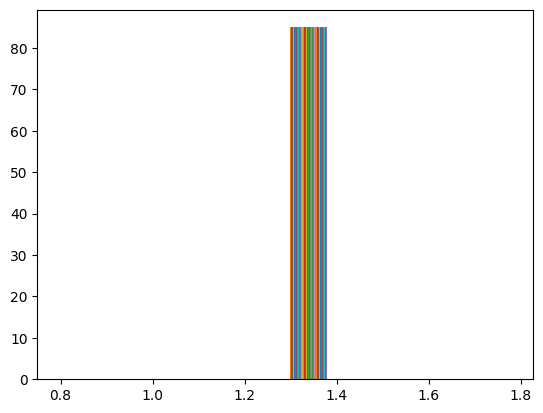

In [194]:
plt.hist(a_hist)

(array([  44.,  115.,  214.,  319.,  457.,  580.,  648.,  706.,  811.,
         926.,  985., 1033., 1087., 1120., 1166., 1264., 1260., 1258.,
        1311., 1355., 1273., 1328., 1412., 1349., 1392., 1434., 1395.,
        1411., 1416., 1451., 1456., 1484., 1499., 1462., 1470., 1422.,
        1473., 1479., 1458., 1476., 1546., 1453., 1471., 1514., 1358.,
        1426., 1405., 1371., 1415., 1469., 1358., 1371., 1479., 1416.,
        1362., 1422., 1403., 1402., 1407., 1363., 1430., 1347., 1324.,
        1341., 1343., 1363., 1323., 1307., 1273., 1334., 1369., 1334.,
        1279., 1302., 1263., 1254., 1231., 1245., 1297., 1236., 1289.,
        1247., 1264., 1252., 1178., 1185., 1230., 1226., 1141., 1173.,
        1148., 1162., 1125., 1131., 1136., 1177., 1123., 1064., 1083.,
        1081.]),
 array([ 0.47842325,  1.47363815,  2.46885305,  3.46406795,  4.45928285,
         5.45449775,  6.44971265,  7.44492755,  8.44014244,  9.43535734,
        10.43057224, 11.42578714, 12.42100204, 13.416216

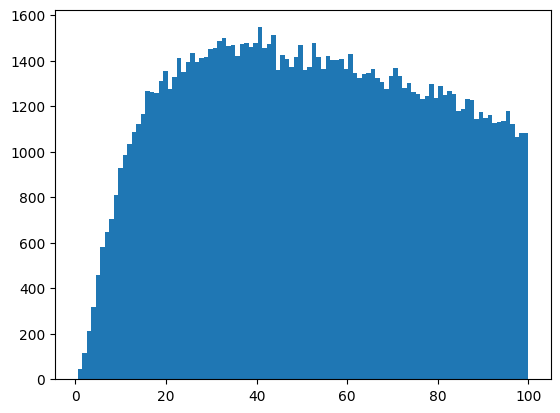

In [26]:
plt.hist(gal_low_alpha['alpha'], bins=100)

In [59]:
def binstat(fam, key, b):
    stat, edges, num = stats.binned_statistic(fam['r'], fam[key]*fam['mass'], statistic = sum, bins = b)
    stat_mass, edges_mass, num_mass = stats.binned_statistic(fam['r'], fam['mass'], statistic = sum, bins = b)
    return stat/stat_mass, edges[:-1]

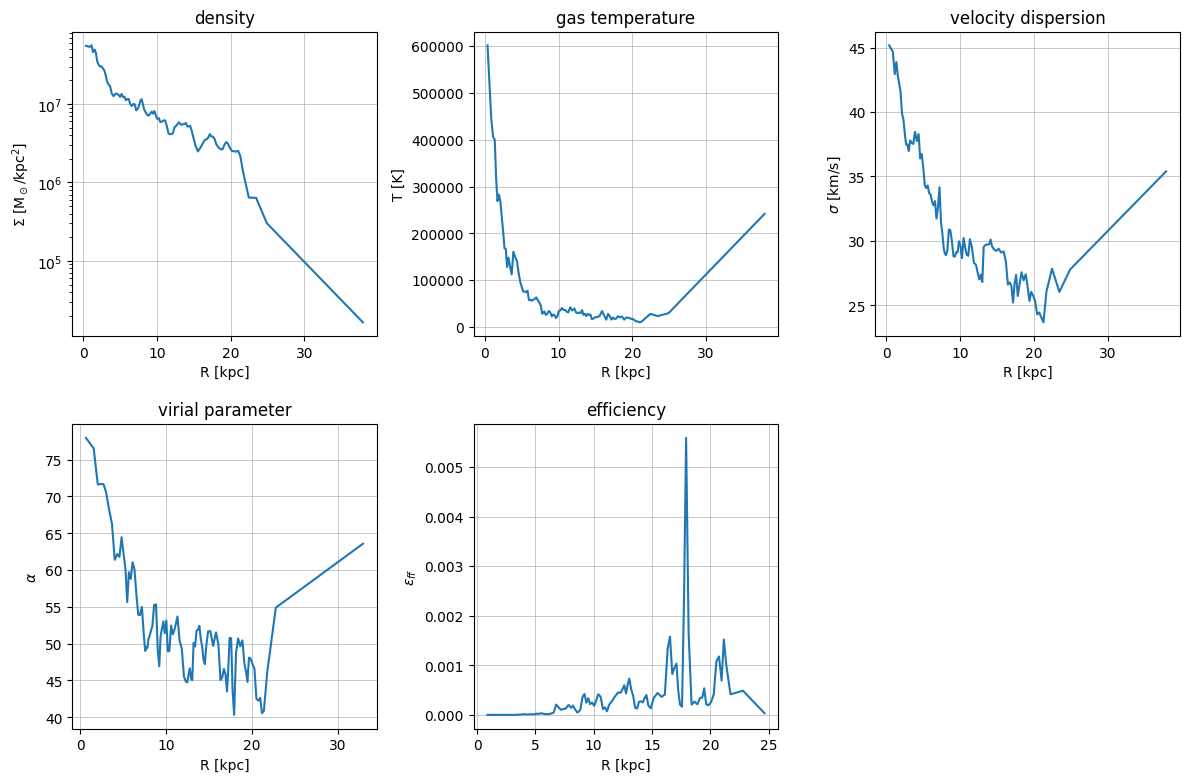

In [46]:
fig = plt.figure(figsize = (12,8))

ax1 = plt.subplot(231)
ax1.plot(pg1['rbins'],pg1['density'])
ax1.semilogy()
ax1.set_title('density')
ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.grid(linewidth = 0.5)
ax1.set_aspect(1./ax1.get_data_ratio())
#ax1.set_xlim(0,50)
#ax1.set_aspect('equal')

ax2 = plt.subplot(232)
ax2.plot(pg1['rbins'], pg1['temp'])
ax2.set_title('gas temperature')
ax2.set_xlabel('R [kpc]')
ax2.set_ylabel('T [K]')
ax2.grid(linewidth = 0.5)
ax2.set_aspect(1./ax2.get_data_ratio())
#ax2.set_xlim(0,50)
#ax2.set_aspect('equal')

ax3 = plt.subplot(233)
ax3.plot(pg1['rbins'], pg1['v_disp'])
ax3.set_title('velocity dispersion')
ax3.set_xlabel('R [kpc]')
ax3.set_ylabel(r'$\sigma$ [km/s]')
ax3.grid(linewidth = 0.5)
ax3.set_aspect(1./ax3.get_data_ratio())
#ax3.set_xlim(0,50)
#ax3.set_aspect('equal')

ax4 = plt.subplot(234)
ax4.plot(pg_low_alpha['rbins'], pg_low_alpha['alpha'])
ax4.set_title('virial parameter')
ax4.set_xlabel('R [kpc]')
ax4.set_ylabel(r'$\alpha$')
ax4.grid(linewidth = 0.5)
ax4.set_aspect(1./ax4.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')

ax5 = plt.subplot(235)
ax5.plot(pg_low_alpha['r'], pg_low_alpha['efficiency'])
ax5.set_title('efficiency')
ax5.set_xlabel('R [kpc]')
ax5.set_ylabel(r'$\epsilon_{ff}$')
ax5.grid(linewidth = 0.5)
ax5.set_aspect(1./ax5.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')


fig.tight_layout()
plt.show()

In [ ]:
#kDtree anschauen -> warum masse_kernel ungleich masse_partikel
#2d histogramme von der anzahl -> boxgröße bestimmen, so dass wir 50 teilchen pro box haben-> daraus die größen bestimmen und damit alpha plotten

